# House Price Predictions: Machine learning process

This notebook is dedicated to the machine learning process of the House Price predictions project. 
The cleaning and exploratory data analysis are documented on the house_prices-solution-eda.ipynb where all choices for the cleaning, selection of variables and features engineering are explained. 

In this notebook, after loading the necessary libraries and data, we will first set up a pipeline that will ensure that the same preprocessing is used on training and test datasets. Using the sklearn library for this will help us achieve quicker computation of the result by allowing us to use the native parallel computation implemented in the library. 

The objective in this part of this project is to compute 3 linear models: 
1. A simple linear model with only 2 variables: For this, we chose to consider Gr Liv Area and Overall Qual, which are the 2 vairables that seem to have the most correlation with our target variable SalePrice 
2. An intermediate model with 10 to 20 variables. We have chosen to consider: Gr Liv Area, Overall Qual, Year Built, Garage Area, Total Bsmt SF, Lot Area, Overall Condition, Electrical, Fireplace QC, Sale Condition, Central Air, MS Zoning, Neighborhood, Sale Type, MS Subclass and Full Bath. 
3. A complex model, including all variables. 

For all model, we will use the Huber Regressor, that allows us to tune the model with 2 parameters: an epsilon parameter that lets us adjust the weight given to the extreme observations in the model, and help us deal with outlying observations and a lambda (alpha in the function) that performs a ridge regularization on the size of the coefficients of the model, giving more weight to the variables that are the most important to explain the variance in the model. 

To evaluate our models, we will use the Mean Absolute Error, that we will try to minimize, and will compare this to a base estimator. 

In addition, to this process, we will also evaluate the residuals of our models on a subset of held out data, in order to see if our models are objectively good models appart from being better than the base estimator. 

Finally, after fitting the models a last time on the complete training set with the optimal parameters, we will use them to compute predictions on the real test set, evaluate their performance on the self-check tool and reprot the scores obtained.  


In [1]:
# Loading libraries

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LassoCV
from scipy.stats import probplot
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
import warnings
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from itertools import chain
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning

from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
import time
from datetime import datetime




In [2]:
# loading data

nomi_var = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", 
            "Land Contour", "Lot Config", "Neighborhood", "Condition 1", "Condition 2", 
            "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
            "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", 
            "Garage Type", "Misc Feature", "Sale Type", "Sale Condition"
            ]
ordi_var = ["Lot Shape", "Utilities", "Land Slope", "Overall Qual", 
            "Overall Cond", "Exter Qual", "Exter Cond", "Bsmt Qual", 
            "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2", 
            "Heating QC", "Electrical", "Kitchen Qual", "Functional", 
            "Fireplace Qu", "Garage Finish", "Garage Qual", "Garage Cond", 
            "Paved Drive", "Pool QC", "Fence"
           ]

conti_var = ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", 
             "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", 
             "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area", "Garage Area", 
             "Wood Deck SF", "Open Porch SF", "Enclosed Porch", "3Ssn Porch", 
             "Screen Porch", "Pool Area", "Misc Val", "SalePrice", "Year Built", 
             "Year Remod/Add", "Garage Yr Blt"
            ]

disc_var = ["Order", "Bsmt Full Bath", "Bsmt Half Bath", 
            "Full Bath", "Half Bath", "Bedroom AbvGr", "Kitchen AbvGr", "TotRms AbvGrd", 
            "Fireplaces", "Garage Cars", "Mo Sold", "Yr Sold"
           ]

# Loading data 
house_raw = pd.read_csv("house-prices.csv", dtype = 'object')
house_raw[disc_var + conti_var] = house_raw[disc_var+ conti_var].copy().astype(float)

#follow documentation recomendations and remove atypical observations: 
house_raw = house_raw.loc[house_raw['Gr Liv Area']<=4000, :]
house_raw = house_raw.reset_index()



In [3]:
# preparing preprocessing pipeline: 
# create custom preprocessor
class PandasPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nomi_vars_ = [#"PID", 
            "MS SubClass", "MS Zoning", "Street", "Alley",
                          "Land Contour", "Lot Config", "Neighborhood", "Condition 1", "Condition 2", 
                          "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                          "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", 
                          "Garage Type", "Misc Feature", "Sale Type", "Sale Condition"
                         ]
        self.ordi_vars_ = ["Lot Shape", "Utilities", "Land Slope", "Overall Qual", 
                           "Overall Cond", "Exter Qual", "Exter Cond", "Bsmt Qual",
                           "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2",
                           "Heating QC", "Electrical", "Kitchen Qual", "Functional", 
                           "Fireplace Qu", "Garage Finish", "Garage Qual", "Garage Cond",
                           "Paved Drive", "Pool QC", "Fence"
                          ]
        self.conti_vars_ = ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", 
                            "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", 
                            "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area", "Garage Area", 
                            "Wood Deck SF", "Open Porch SF", "Enclosed Porch", "3Ssn Porch",
                            "Screen Porch", "Pool Area", "Misc Val" , "Year Built", "Year Remod/Add", "Garage Yr Blt"
                           
                           ]
        self.disc_vars_ = [  
            "Bsmt Full Bath", "Bsmt Half Bath", 
                           "Full Bath", "Half Bath", "Bedroom AbvGr", "Kitchen AbvGr", "TotRms AbvGrd",
                           "Fireplaces",  "Garage Cars", "Mo Sold", "Yr Sold"
                          ]
        self.No_XX_to_add_ = ['Bsmt Qual','Bsmt Cond','BsmtFin Type 1','BsmtFin Type 2','Bsmt Exposure',
                              'Garage Type','Garage Finish','Garage Cond', 'Garage Qual', 'Fireplace Qu',
                              'Fence', 'Alley', 'Misc Feature', 'Pool QC'
                             ]
        self.related_categ_vars_ = [['Bsmt Exposure', 'Bsmt Qual','Bsmt Cond','BsmtFin Type 1','BsmtFin Type 2'], 
                                    ["Garage Cond", "Garage Type", 'Garage Finish', 'Garage Qual'], ["Fireplace Qu"],
                                    ["Misc Feature"], ["Pool QC"],  ["Mas Vnr Type"]
                                   ]
        self.related_quanti_vars_= [["BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", 
                                     "Total Bsmt SF","Bsmt Full Bath", "Bsmt Half Bath"],
                                    ["Garage Area", "Garage Yr Blt"], ["Fireplaces"], ["Misc Val"], ["Pool Area"], ["Mas Vnr Area"]
                                   ]
        self.z_inf_vars_ = ["BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF","2nd Flr SF" , "Low Qual Fin SF",  
                            "Garage Area", "Wood Deck SF", "Open Porch SF", 
                            "Enclosed Porch", "Screen Porch", "3Ssn Porch",
                            "Misc Val", "Pool Area", "Mas Vnr Area" 
                           ]
        self.lst_dict_ordval_ = [{'Ex': '5','Gd': '4', 'TA': '3', 'Fa': '2', 'Po': '1'},
                                 {'Ex': '5','Gd': '4', 'TA': '3', 'Fa': '2', 'Po': '1'},
                                 {'GLQ': '6','ALQ': '5', 'BLQ': '4', 'Rec': '3', 'LwQ': '2', 'Unf': '1'},
                                 {'Reg': '1','IR1': '2','IR2': '3','IR3': '4'},
                                 {'AllPub': '4', 'NoSewr': '3', 'NoSeWa': '2', 'ELO': '1'},
                                 {'Gtl': '3', 'Mod': '2', 'Sev': '1'},
                                 {'Gd': '4','Av': '3', 'Mn': '2', 'No': '1'},
                                 {'SBrkr': '5','FuseA': '4', 'FuseF': '3', 'FuseP': '2', 'Mix': '1'},
                                 {'Typ': '8', 'Min1': '7', 'Min2': '6', 'Mod': '5', 'Maj1': '4', 'Maj2': '3', 'Sev': '2', 'Sal': '1'},
                                 {'Fin': '3', 'RFn': '2', 'Unf': '1'},
                                 {'Y': '3', 'P': '2', 'N': '1'},
                                 {'GdPrv': '4', 'MnPrv': '3', 'GdWo': '2', 'MnWw': '1'}
                                ]

        self.lst_grp_ordval_ = [['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 
                                'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Pool QC'],[ 'Kitchen Qual'],
                                ['BsmtFin Type 1', 'BsmtFin Type 2'], ['Lot Shape'], ['Utilities'], ['Land Slope'], 
                                ['Bsmt Exposure'], ['Electrical'], ['Functional'], ['Garage Finish'], 
                                ['Paved Drive'], ['Fence']
                               ]
        
        #################################################################################
        self.log_vars_ = ['Lot Area', 'Misc Val', 'Mas Vnr Area', 'Total Bsmt SF', 'Lot Frontage', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area',
                          'Garage Area', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch']
        self.sqrt_vars_ = ['Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Wood Deck SF']
        
        self.polynom_vars_ = {'Mas Vnr Area':2, 'BsmtFin SF 1': 2, '2nd Flr SF': 2,
                              'Total Bsmt SF': 2,'Garage Area': 2, 'Year Built': 2, 
                              'Garage Yr Blt': 2 
                             }

        ##################################################################################
        
    # replacing inconsistent data with missing values
    def consistency_check(self, X_df, categ_var, quanti_var = []):    
        X_df = X_df.copy()
        all_var = categ_var + quanti_var
        # define the No_xxx category to check for
        No = "No_" + re.search('([A-Z][a-z]+)', categ_var[0]).group(0)
        # find inconsistent rows within this group of variables
        idx = (X_df[categ_var].eq(No).sum(axis = 1).ne(0)) & ((X_df[categ_var].eq(No).sum(axis = 1).ne(len(categ_var))) | (np.abs(X_df[quanti_var]).gt(0).sum(axis = 1).gt(0))) 
        # replace inconsistencies with na
        X_df.loc[idx, all_var] = np.nan
        return X_df


    # recoding NA for variables associated to categ variables with No_xxx or None
    # after correcting inconsistent data
    # to be sure they are 0 and not NA
    def recod_quantiNA_0(self, X_df, categ_var, quanti_var):
        X_df = X_df.copy()
        # define the No_xxx category to check for
        No = "No_" + re.search('([A-Z][a-z]+)', categ_var[0]).group(0)
        idx = (X_df[categ_var[0]].eq(No)) | (X_df[categ_var[0]].eq('None'))
        # make sure its 0
        X_df.loc[idx, quanti_var] = 0 
        return X_df
    

    def impute_NAs(self, X_df, train_median, train_mode):
        X_df = X_df.copy()
        
        # 1) impute related first
        for cat,quant in zip(self.related_categ_vars_, self.related_quanti_vars_): 

            X_df.loc[:,cat].fillna(train_mode[cat], inplace = True)
            for sub_quant in quant: 
                X_df.loc[X_df[cat[0]].str.contains(r'^No_.+$', na=False) & 
                                    X_df[sub_quant].isna()
                                   ,sub_quant] = X_df.loc[X_df[cat[0]].str.contains(r'^No_.+$', na=False) & 
                                    X_df[sub_quant].isna()
                                   ,sub_quant].fillna(0)
        X_df.loc[:, self.disc_vars_ + self.nomi_vars_ + self.ordi_vars_]= X_df.loc[:, self.disc_vars_ + self.nomi_vars_ + self.ordi_vars_].fillna(train_mode)
        #X_df.loc[:, self.conti_vars_] = X_df.loc[:, self.conti_vars_].fillna(train_median)
        
        return(X_df)
    def impute_NAs_conti(self, X_df, train_distrib): 
        X_df = X_df.copy()
        for idx, feature in enumerate(self.conti_vars_): 
            X_df.loc[X_df[feature].isna(), feature] = np.abs(np.random.normal(train_distrib[idx][0], train_distrib[idx][1], X_df[feature].isna().sum()))
        return X_df
    
    def recode_ordi(self, X_df, lst_var, d): 
        
        X_df= X_df.copy()
        for vas, recode_d in zip(lst_var, d): 
            for va in vas: 
                X_df.loc[:, va] = X_df[va].replace(to_replace = recode_d, value = None)
                
        # replace No_XXXX with 0: 
        unest_lst_var = [item for sublist in lst_var for item in sublist]
        X_df.loc[: , unest_lst_var] = X_df[unest_lst_var].replace(to_replace = r'^No_.+$', value = '0', regex = True)
        X_df.loc[: , unest_lst_var] = X_df.loc[: , unest_lst_var].astype(float)
        return X_df

        
    def preprocess_f(self, X_df):
        # Work on a copy
        X_df = X_df.copy()
        
        
        # Replace NA with meaningful category
        NA_categs = ["No_" + re.search('([A-Z][a-z]+)', x).group(0) for x in self.No_XX_to_add_]
        for idx, vari in enumerate(self.No_XX_to_add_): 
            X_df.loc[:,vari].fillna(NA_categs[idx], inplace = True)
        # check and replace inconsistencies with NA: 
        for cat,quant in zip(self.related_categ_vars_, self.related_quanti_vars_): 
            X_df = self.consistency_check(X_df, categ_var = cat, quanti_var = quant)
            X_df = self.recod_quantiNA_0(X_df, categ_var = cat, quanti_var = quant)

        for quant in self.disc_vars_ + self.conti_vars_: 
            X_df.loc[X_df[quant] <0, quant] = np.nan
            if quant == "Mo Sold": 
                X_df.loc[(X_df[quant] <1) | (X_df[quant] >12), quant] = np.nan
            if quant == "Yr Sold": 
                X_df.loc[(X_df[quant] <2006) | (X_df[quant] >2010), quant] = np.nan
    
        # log and sqrt  transformations: 
        X_df.loc[:,self.log_vars_] = np.log1p(X_df[self.log_vars_])
        X_df.loc[:,self.sqrt_vars_] = np.sqrt(X_df[self.sqrt_vars_])
        
        return X_df
        
    def feature_ing(self, X_df, train_median, train_mode, train_distrib, train_categories, train_max): 
        X_df = X_df.copy()
        # replace outliers with NAs
        #X_df = self.remove_outliers(X_df, train_IQR)
        
        # impute missing data
        X_df= self.impute_NAs(X_df, train_median, train_mode)
        X_df = self.impute_NAs_conti(X_df, train_distrib)
        
        # creating zero inflated variables flag
        for IV in self.z_inf_vars_: 
            X_df[IV+"_YN"] = [1 if x ==0 else 0 for x in X_df[IV]]
        # creating polynomial
        for IV, degree in self.polynom_vars_.items(): 
            for i in range(2, degree+1):
                X_df['{}_{}'.format(IV, i)] = X_df[IV]**i
        # create flags values for Year Remod/Add
        X_df['Year Remod/Add_No_Remod_YN'] = [1 if x == y else 0  for x,y in zip(X_df['Year Built'], X_df['Year Remod/Add'])]
        X_df['Year Remod/Add_1950_YN'] = [1 if ((x != y) & (y ==1950)) else 0  for x,y in zip(X_df['Year Built'], X_df['Year Remod/Add'])]
        X_df.loc[((X_df['Year Remod/Add_No_Remod_YN'] == 1) | (X_df['Year Remod/Add_1950_YN'] == 1)), 'Year Remod/Add'] = 0
        # recoding ordinal scale
        X_df_ord = self.recode_ordi(X_df, self.lst_grp_ordval_, self.lst_dict_ordval_)
        X_df_ord[self.ordi_vars_] = X_df_ord[self.ordi_vars_].astype(float)
        
        return X_df_ord
    
    
    def fit(self, X_df, y_df=None):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame
        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)
         # Save train median for continuous variables
        self.train_median_ = X_df[self.conti_vars_].apply(lambda x: x[x>0].median())
           
        # Save train mode for categorical variables
        self.train_mode_ = X_df[self.disc_vars_+ self.nomi_vars_ + self.ordi_vars_].apply(lambda x: x.mode().values[0]) 
        self.train_distrib_ = X_preprocessed[self.conti_vars_].apply(lambda x: (x[x>0].mean(), x[x>0].std())) 
        self.train_nomi_categories_ = {x: (X_preprocessed[x].value_counts().index)[X_preprocessed[x].value_counts() * 100 / X_preprocessed.shape[0] > 2].values for x in self.nomi_vars_}
        self.train_disc_max_ = {x: X_preprocessed[x].max() for x in self.disc_vars_}
        
        #feature engineering
        X_ing = self.feature_ing(X_preprocessed, self.train_median_, self.train_mode_, self.train_distrib_, self.train_nomi_categories_, self.train_disc_max_)
        
       

        # Save columns names/order for inference time
        self.columns_ = X_ing.columns
        
        self.data_ = X_ing
        

        return self
    
    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed_te = self.preprocess_f(X_df)
        
        #feature engineering
        X_ing_te = self.feature_ing(X_preprocessed_te, self.train_median_, self.train_mode_, self.train_distrib_, self.train_nomi_categories_, self.train_disc_max_)
        
        # Make sure to have the same features
        X_reindexed = X_ing_te.reindex(columns=self.columns_, fill_value=0)
        self.data_reindexed_ = X_reindexed

        return X_reindexed

The above code sets up custom preprocessor that  will prepare thed data: remove errors and inconsistencies, impute missing values, create additional binary variables as well as polynomials and transform the data. This will be used in a pipeline object, allowing for all descriptive output necessary for imputation and fitting using only data from the test set and applying them to the test, without data leakage. 

First, we split the data between the between train and validation (for final sanity check before fitting the whole model and predicting the test set). 

In [4]:
#Preparing the data: Separating  X and y, log-transforming y and splitting between train and validation (for final sanity check before fitting the whole model and predicting the test set)
X = house_raw.drop('SalePrice', axis=1)
y = house_raw.SalePrice.copy()
y = np.log1p(y)

#holding out a small subset for final fitting with optimized parameters and residuals diagnostic
X_val, X_te, y_val, y_te = train_test_split(X, y, test_size=0.3, random_state=3092021)

## 1. Simple model 

We are now ready to start working on the simple model. For the pipleine to be complete, we need first to compute some lists containing the varaibles that will be encoded with one hot encoding and the ones that will be simply scaled for the continuous variables. We will also need to compute the list of categories that are available in the categorical feature. 
for one hot encoding, we need decide to drop the first category, as this will be our reference category and including it would introduce redundancy in the data set. 
For the Standardization, we use  RobustScaler, as we have establish that the distribution of our continuous variables is not perfectly normal. 
Once all elements are initialized, we create the final pipeline. 

In [5]:
# Creating all steps for simple model pipeline and cross validation
# simple model (Gr Liv Area and Overall Qual)


all_additional_variables = PandasPreprocessor().fit(X_val, y_val).columns_.values

onehot_columns = ['Overall Qual']
other_columns = [x  for y in  ['Gr Liv Area'] for x in all_additional_variables if y in x]

simple_categ_categories = np.array([np.sort(PandasPreprocessor().fit(house_raw).data_[x].unique()) for x in onehot_columns])


# One-hot encoding for non-numerical columns

onehot_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error', drop = 'first', categories = simple_categ_categories))
])

other_transformer = Pipeline([
    #('scaler', StandardScaler())
    ('scaler', RobustScaler())
])

# Create preprocessor
preprocessor_model = ColumnTransformer([
    ('onehot', onehot_transformer, onehot_columns),
    ('other', other_transformer, other_columns)
])

regressor_simple=Pipeline([
    ('cleaning', PandasPreprocessor()),
    ('preprocessor', preprocessor_model),
    ('huber', HuberRegressor(max_iter = 100000))
])



Finally, as we will be using cross validation for parameter tuning, we define a scorer for the gridCV function, in order to compute the Mean Absolute Error, expressed in the original scale (instead of the log of SalePrice) that we will be minimizing to find the best parameters for our model. 

In [6]:
warnings.simplefilter('ignore', FutureWarning)
#setup custom scorer to get score in correct scale
def scaleMAE(y_true, y_pred):
    diff =  MAE(np.exp(y_true)-1, np.exp(y_pred)-1)
    return diff

#cross validation
gridCV_simple = GridSearchCV(regressor_simple,
                      param_grid={'huber__alpha' : np.logspace(-6, 6, num=20), 'huber__epsilon' : [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]},
                      cv = ShuffleSplit(n_splits=10, test_size=.5, random_state = 15092021),
                      refit=True,
                      scoring=make_scorer(scaleMAE, greater_is_better=False),
                      return_train_score=True,
                             verbose =3,
                      n_jobs = 8)


start_time = time.clock()
print(datetime.now())
gridCV_simple.fit(X_val, y_val)
print("--- %s seconds ---" % (time.clock() - start_time))

2021-09-16 19:39:33.941526
Fitting 10 folds for each of 220 candidates, totalling 2200 fits
--- 529.2215096 seconds ---


In [7]:
#results = gridCV.cv_results_
pd_result_simple = pd.DataFrame({'alpha': gridCV_simple.cv_results_['param_huber__alpha'].data[~gridCV_simple.cv_results_['param_huber__alpha'].mask].astype(np.float64),
                          'epsilon': ['eps:' + x for x in gridCV_simple.cv_results_['param_huber__epsilon'].data[~gridCV_simple.cv_results_['param_huber__epsilon'].mask].astype(str)], 
                          'mean_MAE_train': -gridCV_simple.cv_results_['mean_train_score'],
                          'std_MAE_train': gridCV_simple.cv_results_['std_train_score'],
                          'mean_MAE_test': -gridCV_simple.cv_results_['mean_test_score'], 
                          'std_MAE_test': gridCV_simple.cv_results_['std_test_score']
                         })

In [8]:
best_params_simple = gridCV_simple.cv_results_['params'][gridCV_simple.best_index_]

First, we display the validation curves for the tuning of the parameters:

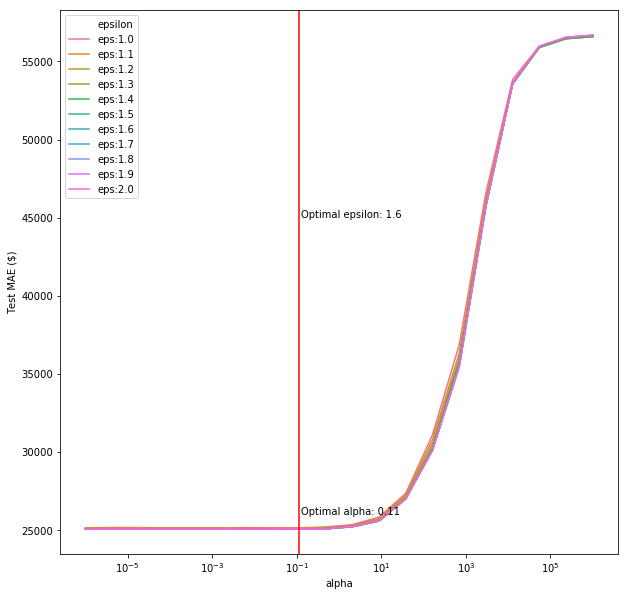

In [9]:
plt.figure(figsize = (10,10))
ax = plt.gca()

sns.lineplot(data=pd_result_simple, x="alpha", y="mean_MAE_test", hue="epsilon")
ax.axvline(x=best_params_simple['huber__alpha'], color='r')

ax.set_xscale('log')
plt.text(best_params_simple['huber__alpha'] + 0.01, 26000, 'Optimal alpha: {}'.format(round(best_params_simple['huber__alpha'], 2)))
plt.text(best_params_simple['huber__alpha'] + 0.01, 45000, 'Optimal epsilon: {}'.format(round(best_params_simple['huber__epsilon'], 2)))
plt.ylabel('Test MAE ($)')
plt.show()

We can see that for all epsilons, the validations curves are very similar. 
The optimal alpha is: 0.11, while the optimal epsilon chosen by the cross validation is: 1.6. 
A small alpha is as expected, as we do not have a lot of variables in the dataset. 

The following figure will display the coefficients according to alpha, at the optimal epsilon: 


In [10]:
alphas = np.logspace(-6, 6, num=20)

coefs = []
for a in alphas:
    regressor_simple_diag=Pipeline([
    ('cleaning', PandasPreprocessor()),
    ('preprocessor', preprocessor_model),
    ('huber', HuberRegressor(alpha = a, epsilon = best_params_simple['huber__epsilon']))
])

    regressor_simple_diag.fit(X_val, y_val)
    coefs.append(regressor_simple_diag.named_steps['huber'].coef_)


In [11]:
#getting coefficients names
coefficients = [re.sub(r'x.*_', 'Overall Qual_', substring) for substring in regressor_simple_diag.named_steps['preprocessor'].named_transformers_['onehot'].named_steps['encoder'].get_feature_names()] + other_columns
coefficients



['Overall Qual_2.0',
 'Overall Qual_3.0',
 'Overall Qual_4.0',
 'Overall Qual_5.0',
 'Overall Qual_6.0',
 'Overall Qual_7.0',
 'Overall Qual_8.0',
 'Overall Qual_9.0',
 'Overall Qual_10.0',
 'Gr Liv Area']

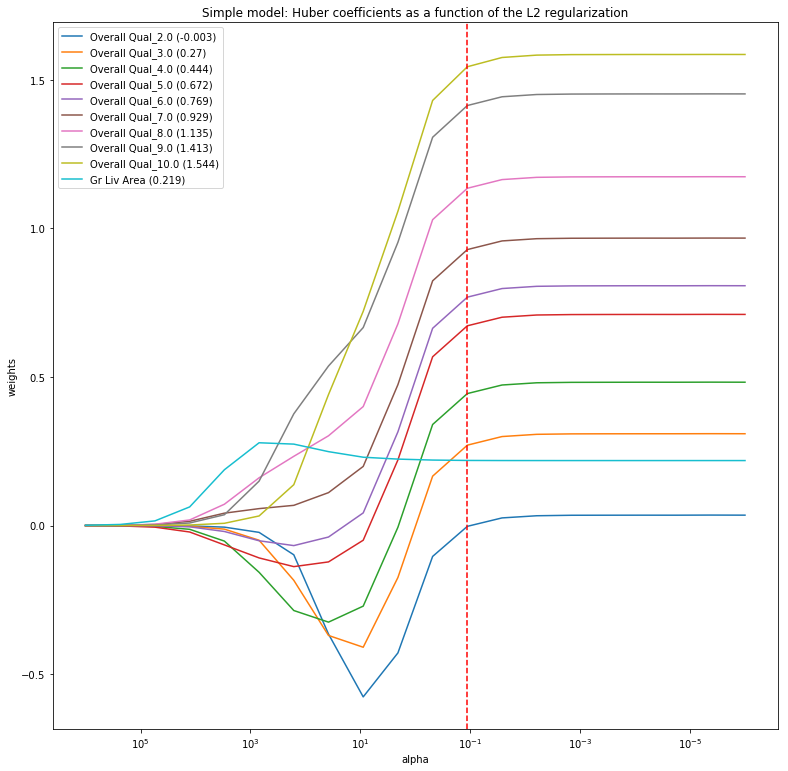

In [12]:
reg_simple_result = pd.DataFrame(coefs, columns = coefficients, index = alphas)


# #############################################################################
# Display results
plt.figure(figsize = (13,13))
ax = plt.gca()

for i in coefficients:    
    #ax.plot(kind='line',x=alphas,y=i, data = reg_simple_result)
    sns.lineplot(x=alphas, y=reg_simple_result[i], label = '{} ({})'.format(i, round(reg_simple_result.loc[best_params_simple['huber__alpha']][i], 3)))
    
ax.axvline(x=best_params_simple['huber__alpha'], color = 'r', linestyle = '--')

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Simple model: Huber coefficients as a function of the L2 regularization')
plt.legend()
plt.axis('tight')
plt.show()

We can see that the biggest coefficients are for the highest categories of Overall quality, meaning that in this model, being rated highly on the overall quality is more important than the living surface area. 

Finally, we evaluate the quality of this model on the held out data set. 

In [13]:
#final fit on held out data for diagnostics purposes

regressor_simple_diag=Pipeline([
    ('cleaning', PandasPreprocessor()),
    ('preprocessor', preprocessor_model),
    ('huber', HuberRegressor(alpha = best_params_simple['huber__alpha'], epsilon = best_params_simple['huber__epsilon']))
])

regressor_simple_diag.fit(X_val, y_val)
print('Final Test MAE: {}$'.format(round(MAE(np.exp(y_te)-1, np.exp(regressor_simple_diag.predict(X_te))-1))))

Final Test MAE: 23485.0$


In average, the predictions are 23485 dollars away from their true value.
In order to evaluate if this model is an objectively good model, we plots multiple figures to diagnose the residuals and establish if all assumptions for the linear model are met: 

In [14]:
# plotting residuals to diagnose quality of the model: 

def diagnose_plots(x_var, y_var, y_pred): 
    fig, axes = plt.subplots(2, 2, figsize=(20,20))
    residuals = y_var-y_pred
    axes[0,0].scatter(x_var,y_var, alpha = 0.3, label = "data")
    axes[0,0].scatter(x_var,y_pred, alpha = 0.3, label = "predictions")
    axes[0,0].set_title('Sale Price vs. {}'.format(x_var.name))
    axes[0,0].text(x =750, y = 550000, s='r² = {}'.format(round(r2_score(np.log1p(y_var), np.log1p(y_pred)), 2)))
    axes[0,0].set_xlabel(x_var.name)
    axes[0,0].set_ylabel('SalePrice ($)')
    axes[0,0].legend()
    
    #2) residuals histogram
    axes[0,1].hist(residuals, bins = 20)
    axes[0,1].set_title("Histogram of residuals")

    #3) residuals vs fitted
    axes[1,0].scatter(y_pred, residuals )
    axes[1,0].axhline(0, c = 'r')
    axes[1,0].set_title("Residuals vs predictions")
    axes[1,0].set_xlabel("Predictions")
    axes[1,0].set_ylabel("Residuals")
    
    #4) residuals qqplot
    axes[1,1] = probplot(residuals, dist="norm", plot = plt);
    fig.suptitle("Residuals diagnostic")
    plt.show()
    return 

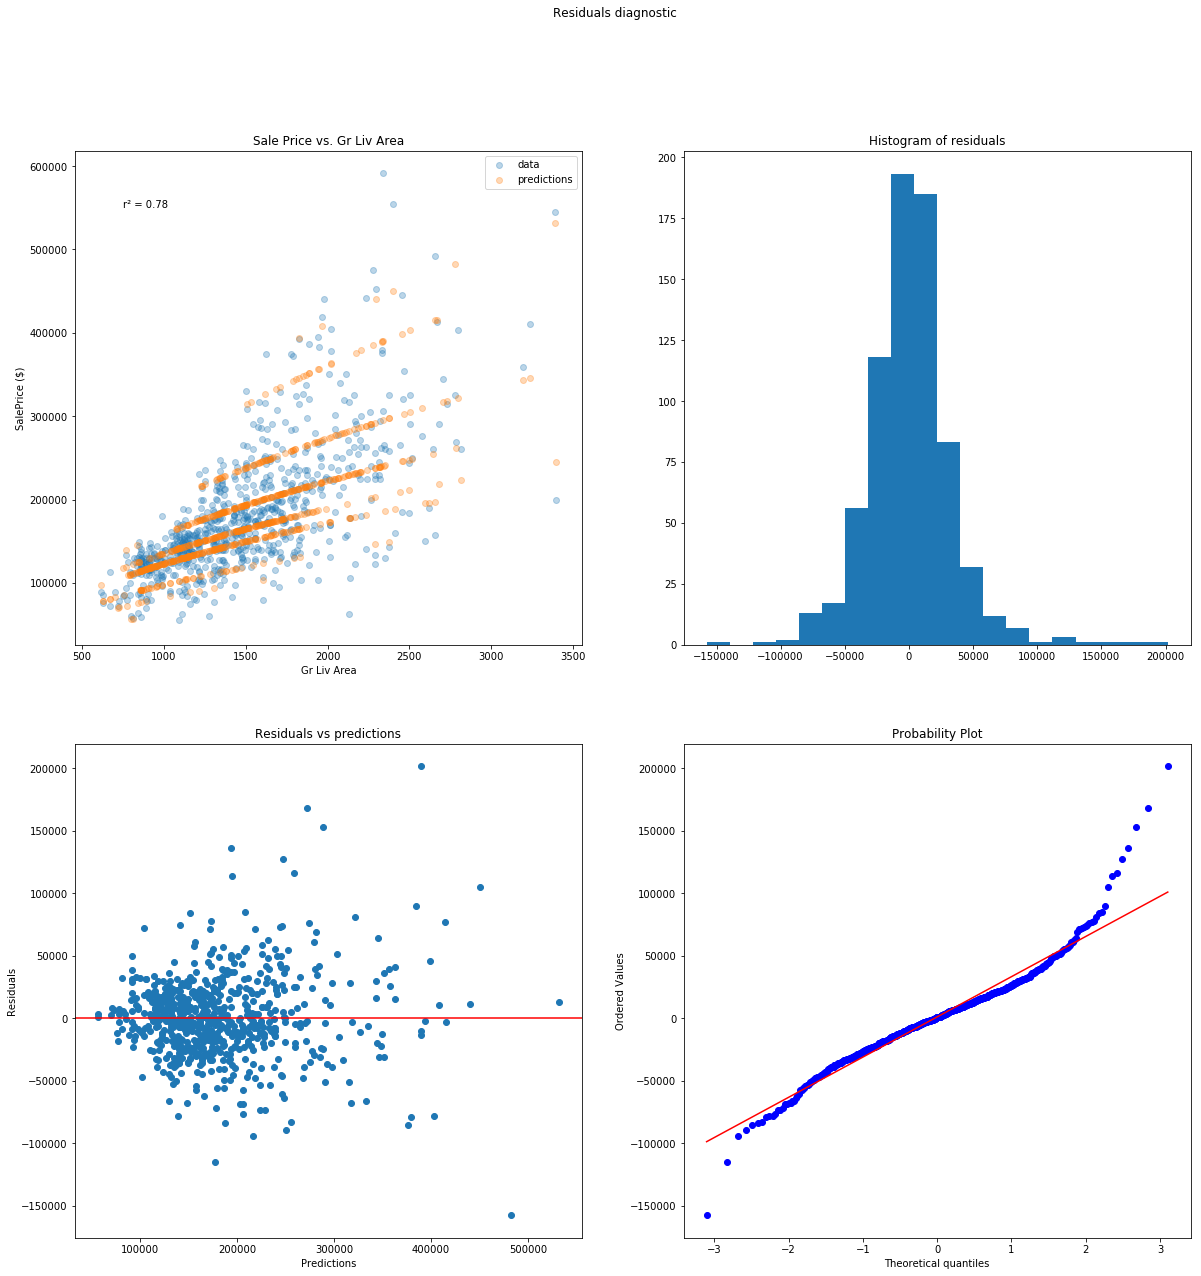

In [15]:
diagnose_plots(X_te['Gr Liv Area'], np.exp(y_te)-1, np.exp(regressor_simple_diag.predict(X_te))-1)

We can see that the predictions tend to follow a line per category of Overall Qual. The r² is 0.78, meaning that 78% of the variance can be explained by our model. 

The residuals, tend to follow a symmetric distribution, but deviate from a normal distribution for extreme quantiles. The residuals tend to be homogeneously distributed around 0 for the most part, but tend to spread out for the more extreme values. These observations can be explained by the under representations of houses with high prices in the dataset, resulting in the predictions being of lesser qualities for these types of houses. 

Now that we have fitted our first simple model, let's work on our intermediate model. 

## 2. Intermediate model 

For this model, we will include: 

* 'Gr Liv Area', 
* 'Year Built', 
* 'Total Bsmt SF', 
* 'Lot Area', 
* 'Garage Area'
* 'Overall Cond', 
* 'Electrical', 
* 'Central Air', 
* 'Fireplace Qu',  
* 'Sale Type', 
* 'Sale Condition', 
* 'Overall Qual', 
* 'MS Zoning', 
* "MS SubClass", 
* 'Neighborhood', 
* 'Full Bath'

In addition to computing the list of the columns for one hot encoding and the continuous one that will be standardized, we will also keep the list of categorical variables that already only have 0 and 1 (additional variables created to manage the 0 inflated variables in the model), that don't need to be further processed but need to appear in the column transformer pipeline to be kept in the model.   

In [16]:

#Intermediate model: 

inter_conti_var = ['Gr Liv Area', 'Year Built', 'Total Bsmt SF', 'Lot Area', 'Garage Area']
inter_categ_var = ['Overall Cond','Electrical', 'Central Air', 'Fireplace Qu',  'Sale Type', 'Sale Condition', 
                   'Overall Qual', 'MS Zoning', "MS SubClass", 'Neighborhood', 'Full Bath']
inter_categ_categories = np.array([np.sort(PandasPreprocessor().fit(house_raw).data_[x].unique()) for x in inter_categ_var])


# One-hot encoding for non-numerical columns
onehot_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', categories = inter_categ_categories))
])

other_transformer = Pipeline([
    ('scaler', RobustScaler())
])


onehot_columns = inter_categ_var
other_columns = [x  for y in inter_conti_var for x in all_additional_variables if y in x]
passthrough_columns = [id_var for id_var in other_columns if '_YN' in id_var]
other_columns = [id_var for id_var in other_columns if '_YN' not in id_var]


# Create preprocessor
preprocessor_model = ColumnTransformer([
    ('onehot', onehot_transformer, onehot_columns),
    ('other', other_transformer, other_columns),
    ('pass','passthrough', passthrough_columns)
])
regressor=Pipeline([
    ('cleaning', PandasPreprocessor()),
    ('preprocessor', preprocessor_model),
    ('huber', HuberRegressor(max_iter = 1000000))
])


gridCV_inter = GridSearchCV(regressor,
                      param_grid={'huber__alpha' : np.logspace(-6, 6, num=20), 'huber__epsilon' : [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]},
                      cv = ShuffleSplit(n_splits=10, test_size=.5, random_state = 15092021),
                      refit=True,
                      scoring=make_scorer(scaleMAE, greater_is_better=False),
                      return_train_score = True, 
                      error_score = 'raise',
                      verbose = 3,
                      n_jobs = 8)


start_time = time.clock()
print(datetime.now())
gridCV_inter.fit(X_val, y_val)
print("--- %s seconds ---" % (time.clock() - start_time))


2021-09-16 19:48:50.674273
Fitting 10 folds for each of 220 candidates, totalling 2200 fits
--- 837.2172704000001 seconds ---


In [17]:
pd_result_inter = pd.DataFrame({'alpha': gridCV_inter.cv_results_['param_huber__alpha'].data[~gridCV_inter.cv_results_['param_huber__alpha'].mask].astype(np.float64),
                          'epsilon': ['eps:' + x for x in gridCV_inter.cv_results_['param_huber__epsilon'].data[~gridCV_inter.cv_results_['param_huber__epsilon'].mask].astype(str)], 
                          'mean_MAE_train': -gridCV_inter.cv_results_['mean_train_score'],
                          'std_MAE_train': gridCV_inter.cv_results_['std_train_score'],
                          'mean_MAE_test': -gridCV_inter.cv_results_['mean_test_score'], 
                          'std_MAE_test': gridCV_inter.cv_results_['std_test_score']
                         })

In [18]:
best_params_inter = gridCV_inter.cv_results_['params'][gridCV_inter.best_index_]

As previously, we display the validation curves for the tuning of the parameters.

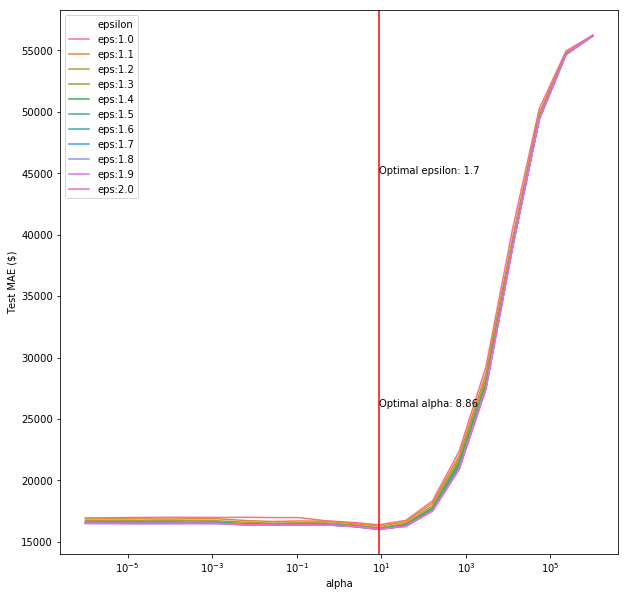

In [19]:
plt.figure(figsize = (10,10))
ax = plt.gca()

sns.lineplot(data=pd_result_inter, x="alpha", y="mean_MAE_test", hue="epsilon")
ax.axvline(x=best_params_inter['huber__alpha'], color='r')

ax.set_xscale('log')
plt.text(best_params_inter['huber__alpha'] + 0.01 , 26000, 'Optimal alpha: {}'.format(round(best_params_inter['huber__alpha'], 2)))
plt.text(best_params_inter['huber__alpha'] + 0.01, 45000, 'Optimal epsilon: {}'.format(round(best_params_inter['huber__epsilon'], 2)))
plt.ylabel('Test MAE ($)')
plt.show()

Compared to the simple model, the optimal regularization parameter is higher, which is expected as we have a lot of variables that might be introducing noise. 
Similarly as for the simple model, we will plot the coefficients as a function of the l2 regularization parameter (all, then only the most important coefficients). 

In [20]:
alphas = np.logspace(-6, 6, num=20)

coefs = []
for a in alphas:
    regressor_inter_diag=Pipeline([
    ('cleaning', PandasPreprocessor()),
    ('preprocessor', preprocessor_model),
    ('huber', HuberRegressor(max_iter = 1000000, alpha = a, epsilon = best_params_inter['huber__epsilon']))
])

    regressor_inter_diag.fit(X_val, y_val)
    coefs.append(regressor_inter_diag.named_steps['huber'].coef_)

In [21]:
#getting coefficients names
coefficients = [re.sub(r'x.*_', '{}_'.format(feature), substring) for substring, feature in zip(regressor_inter_diag.named_steps['preprocessor'].named_transformers_['onehot'].named_steps['encoder'].get_feature_names(), np.repeat(onehot_columns, np.array([len(np.sort(PandasPreprocessor().fit(house_raw).data_[x].unique())) for x in inter_categ_var])))] + other_columns + passthrough_columns


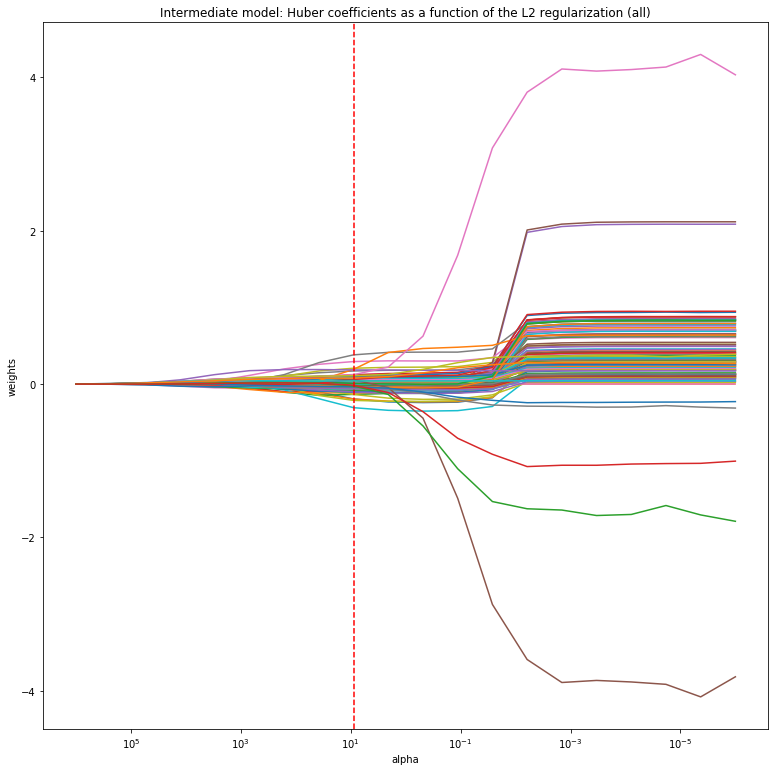

In [22]:
reg_inter_result = pd.DataFrame(coefs, columns = coefficients, index = alphas)


# #############################################################################
# Display results
plt.figure(figsize = (13,13))
ax = plt.gca()

for i in coefficients:    
    #ax.plot(kind='line',x=alphas,y=i, data = reg_simple_result)
    sns.lineplot(x=alphas, y=reg_inter_result[i])
    
ax.axvline(x=best_params_inter['huber__alpha'], color = 'r', linestyle = '--')

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Intermediate model: Huber coefficients as a function of the L2 regularization (all)')
#plt.legend()
plt.axis('tight')
plt.show()

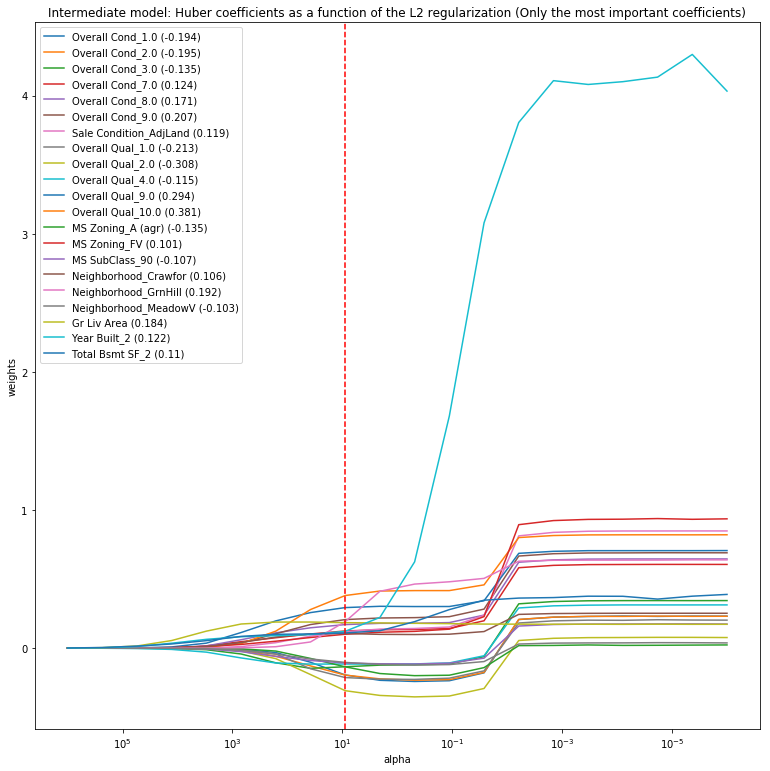

In [23]:
# #############################################################################
# Display results
plt.figure(figsize = (13,13))
ax = plt.gca()

for i in coefficients:    
    if np.abs(round(reg_inter_result.loc[best_params_inter['huber__alpha']][i], 3)) > 0.1:
        sns.lineplot(x=alphas, y=reg_inter_result[i], label = '{} ({})'.format(i, round(reg_inter_result.loc[best_params_inter['huber__alpha']][i], 3)))
    
ax.axvline(x=best_params_inter['huber__alpha'], color = 'r', linestyle = '--')

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Intermediate model: Huber coefficients as a function of the L2 regularization (Only the most important coefficients)')
plt.legend()
plt.axis('tight')
plt.show()

Among the most important coefficients, we can find Overall Quality, with higher rates (10,9) being associated with higher proces and lower rates (4, 2, 1) being associated with a decrease in price. The same goes for Overall condition.  
Other variables with categories being important in the prediction of Sale Price are Neighborhood, with MeadowV being asociated with a decrease in prices, while Crawfor and GrnHill are associated with higher prices. There is also an important positive linear relationship between Gr Liv Area and Sale Price. 

Finally, as for the simple model, we evaluate the quality of this model on the held out data set. 

In [24]:
#final fit on held out data for diagnostics purposes
regressor_inter_diag=Pipeline([
    ('cleaning', PandasPreprocessor()),
    ('preprocessor', preprocessor_model),
    ('huber', HuberRegressor(max_iter = 100000, alpha = best_params_inter['huber__alpha'], epsilon = best_params_inter['huber__epsilon']))
])

regressor_inter_diag.fit(X_val, y_val)
print('Final Test MAE: {}$'.format(round(MAE(np.exp(y_te)-1, np.exp(regressor_inter_diag.predict(X_te))-1))))

Final Test MAE: 14486.0$


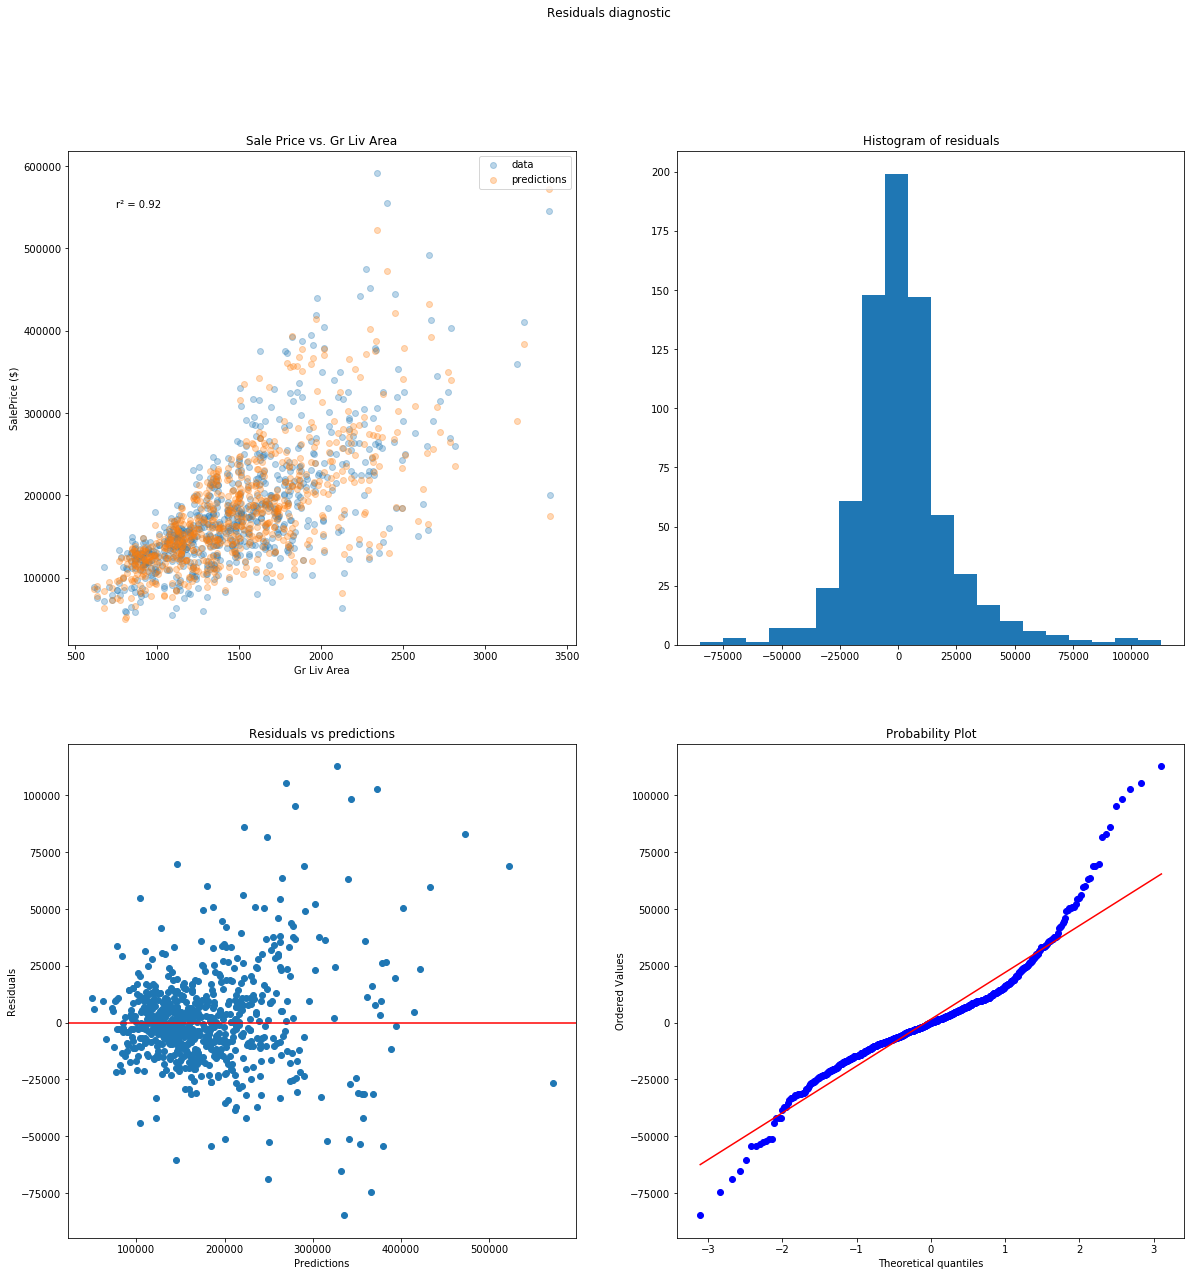

In [25]:
diagnose_plots(X_te['Gr Liv Area'], np.exp(y_te)-1, np.exp(regressor_inter_diag.predict(X_te))-1)

In average, our predictions are 14532 dollars away from their true values and 92% of the variance can be explained by our model. We can see that similarly as for the simple model, our residuals follow a symmetrical distribution, with extreme quantiles tending to be under estimated (for high Prices) or over estimated (for low Prices). As reviously, the residuals tend to be more spread out for higher prices, but we can see that overall the homoscedasticity tend to be respected. 

This model seem sound for predictions. 

## 3. Complex model 
Finally, we will fit a model including all of the variables in the dataset: 

In [27]:

#Complex model: 

complex_conti_var = ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", 
                            "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", 
                            "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area", "Garage Area", 
                            "Wood Deck SF", "Open Porch SF", "Enclosed Porch", "3Ssn Porch",
                            "Screen Porch", "Pool Area", "Misc Val", "SalePrice", 
                            "Year Built", "Year Remod/Add", "Garage Yr Blt"
                           ]
complex_categ_var = ["MS SubClass", "MS Zoning", "Street", "Alley",
                          "Land Contour", "Lot Config", "Neighborhood", "Condition 1", "Condition 2", 
                          "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                          "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", 
                          "Garage Type", "Misc Feature", "Sale Type", "Sale Condition", "Lot Shape", "Utilities", "Land Slope", "Overall Qual", 
                           "Overall Cond", "Exter Qual", "Exter Cond", "Bsmt Qual",
                           "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2",
                           "Heating QC", "Electrical", "Kitchen Qual", "Functional", 
                           "Fireplace Qu", "Garage Finish", "Garage Qual", "Garage Cond",
                           "Paved Drive", "Pool QC", "Fence",  "Order",
    "Bsmt Full Bath", "Bsmt Half Bath", 
                           "Full Bath", "Half Bath", "Bedroom AbvGr", "Kitchen AbvGr", "TotRms AbvGrd",
                           "Fireplaces",  "Garage Cars", "Mo Sold", "Yr Sold"
                          ]
complex_categ_categories = np.array([np.sort(PandasPreprocessor().fit(house_raw).data_[x].unique()) for x in complex_categ_var])


# One-hot encoding for non-numerical columns
onehot_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', categories = complex_categ_categories))
])

other_transformer = Pipeline([
    ('scaler', RobustScaler())
])


onehot_columns = complex_categ_var
other_columns = [x  for y in complex_conti_var for x in all_additional_variables if y in x]
passthrough_columns = [id_var for id_var in other_columns if '_YN' in id_var]
other_columns = [id_var for id_var in other_columns if '_YN' not in id_var]


# Create preprocessor
preprocessor_model = ColumnTransformer([
    ('onehot', onehot_transformer, onehot_columns),
    ('other', other_transformer, other_columns),
    ('pass','passthrough', passthrough_columns)
])
regressor=Pipeline([
    ('cleaning', PandasPreprocessor()),
    ('preprocessor', preprocessor_model),
    ('huber', HuberRegressor(max_iter = 1000000))

])
def scaleMAE(y_true, y_pred):
    diff =  MAE(np.exp(y_true)-1, np.exp(y_pred)-1)
    print(diff)
    return diff


gridCV_complex = GridSearchCV(regressor,
                      param_grid={'huber__alpha' : np.logspace(-6, 6, num=20), 'huber__epsilon' : [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]},
                      cv = ShuffleSplit(n_splits=10, test_size=.5, random_state = 15092021),
                      refit=True,
                      scoring=make_scorer(scaleMAE, greater_is_better=False),
                      return_train_score = True, 
                      error_score = np.nan,
                      verbose = 3,
                      n_jobs = 8)


start_time = time.clock()
print(datetime.now())
gridCV_complex.fit(X_val, y_val)
print("--- %s seconds ---" % (time.clock() - start_time))

2021-09-16 20:05:33.794428
Fitting 10 folds for each of 220 candidates, totalling 2200 fits


C:\Users\Valou\anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [-16175.08929494 -15976.78932898 -16007.33104995 -16067.21368447
 -16061.47464089 -16058.54610794 -16067.00375754 -16064.92830543
 -16088.05025818 -16122.24905091 -16140.1853297  -16332.02204325
 -15973.35560999 -16071.15367006 -16069.66195487 -16042.15545516
 -16092.71817215 -16092.77484361 -16091.30184032 -16159.95966046
 -16125.09100587 -16142.9799454  -16244.65355745 -15985.29807779
 -16058.55545672 -16062.82922631 -16034.53180333 -16056.92555863
 -16103.73520505 -16046.43554371 -16095.93727645 -16102.0278804
 -16152.98038454 -16290.03737175 -16036.64507572 -15999.04267254
 -16065.11705442 -16026.78325517 -16041.73780693 -16094.45383441
 -16091.873457   -16082.08209552 -16122.18015697 -16140.78656866
 -16057.94297159 -15976.61622094 -16009.18464251 -16116.9396858
 -16059.25241924 -16064.57842084 -16076.25758518 -16108.92447466
 

--- 4209.7395134 seconds ---


In [28]:
pd_result_complex = pd.DataFrame({'alpha': gridCV_complex.cv_results_['param_huber__alpha'].data[~gridCV_complex.cv_results_['param_huber__alpha'].mask].astype(np.float64),
                          'epsilon': ['eps:' + x for x in gridCV_complex.cv_results_['param_huber__epsilon'].data[~gridCV_complex.cv_results_['param_huber__epsilon'].mask].astype(str)], 
                          'mean_MAE_train': -gridCV_complex.cv_results_['mean_train_score'],
                          'std_MAE_train': gridCV_complex.cv_results_['std_train_score'],
                          'mean_MAE_test': -gridCV_complex.cv_results_['mean_test_score'], 
                          'std_MAE_test': gridCV_complex.cv_results_['std_test_score']
                         })

In [29]:
best_params_complex = gridCV_complex.cv_results_['params'][gridCV_complex.best_index_]

As Previously, we display the validation curves: 

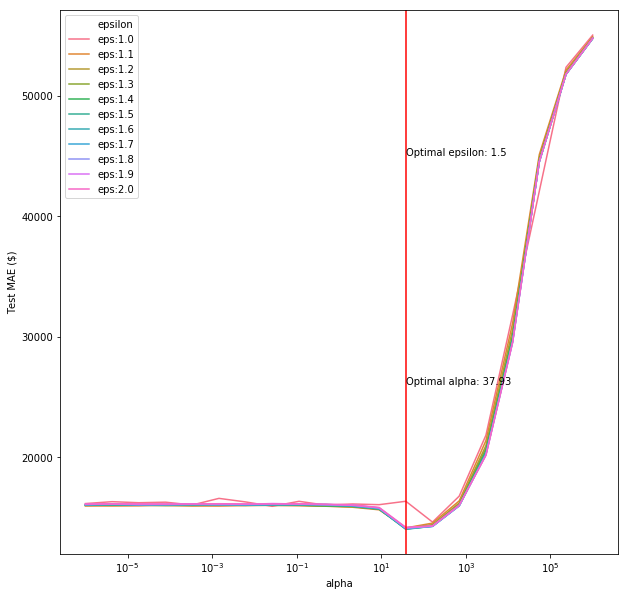

In [30]:
plt.figure(figsize = (10,10))
ax = plt.gca()

sns.lineplot(data=pd_result_complex, x="alpha", y="mean_MAE_test", hue="epsilon")
ax.axvline(x=best_params_complex['huber__alpha'], color='r')

ax.set_xscale('log')
plt.text(best_params_complex['huber__alpha'] + 0.1, 26000, 'Optimal alpha: {}'.format(round(best_params_complex['huber__alpha'], 2)))
plt.text(best_params_complex['huber__alpha'] + 0.1, 45000, 'Optimal epsilon: {}'.format(round(best_params_complex['huber__epsilon'], 2)))
plt.ylabel('Test MAE ($)')
plt.show()

Here, the optimal alpha is quite large, which might be explained by the very large number of variables in the model. 
Similarly as for the simple and intermediate model, we will plot the coefficients as a function of the l2 regularization parameter (all, then only the most important coefficients). 

In [31]:
warnings.simplefilter('ignore', ConvergenceWarning)
alphas = np.logspace(-6, 6, num=20)

coefs = []
for a in alphas:
    regressor_complex_diag=Pipeline([
    ('cleaning', PandasPreprocessor()),
    ('preprocessor', preprocessor_model),
    ('huber', HuberRegressor(max_iter = 100000000, alpha = a, epsilon = best_params_complex['huber__epsilon']))
])

    regressor_complex_diag.fit(X_val, y_val)
    coefs.append(regressor_complex_diag.named_steps['huber'].coef_)

In [32]:
#getting coefficients names
coefficients = [re.sub(r'x.*_', '{}_'.format(feature), substring) for substring, feature in zip(regressor_complex_diag.named_steps['preprocessor'].named_transformers_['onehot'].named_steps['encoder'].get_feature_names(), np.repeat(onehot_columns, np.array([len(np.sort(PandasPreprocessor().fit(house_raw).data_[x].unique())) for x in complex_categ_var])))] + other_columns + passthrough_columns


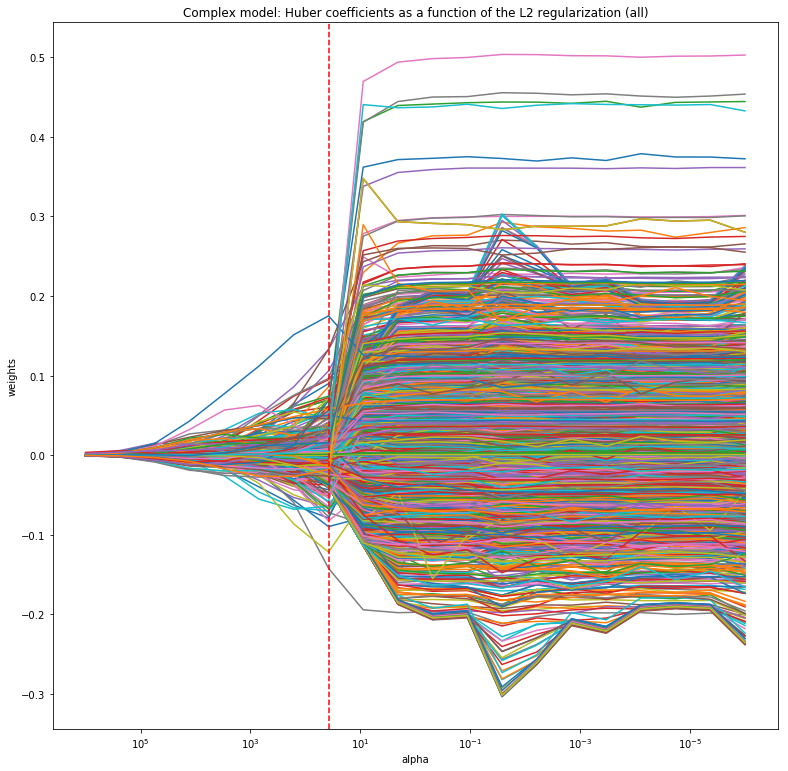

In [33]:
reg_complex_result = pd.DataFrame(coefs, columns = coefficients, index = alphas)


# #############################################################################
# Display results
plt.figure(figsize = (13,13))
ax = plt.gca()

for i in coefficients:    
    #ax.plot(kind='line',x=alphas,y=i, data = reg_simple_result)
    sns.lineplot(x=alphas, y=reg_complex_result[i])
    
ax.axvline(x=best_params_complex['huber__alpha'], color = 'r', linestyle = '--')

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Complex model: Huber coefficients as a function of the L2 regularization (all)')
#plt.legend()
plt.axis('tight')
plt.show()

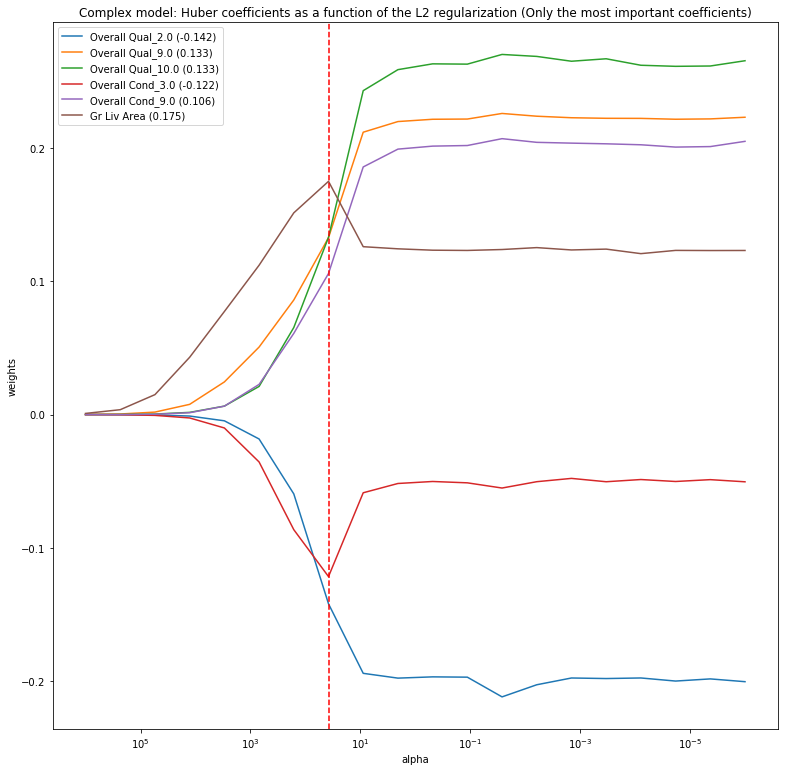

In [34]:
# #############################################################################
# Display results
plt.figure(figsize = (13,13))
ax = plt.gca()

for i in coefficients:    
    if np.abs(round(reg_complex_result.loc[best_params_complex['huber__alpha']][i], 3)) > 0.1:
        sns.lineplot(x=alphas, y=reg_complex_result[i], label = '{} ({})'.format(i, round(reg_complex_result.loc[best_params_complex['huber__alpha']][i], 3)))
    
ax.axvline(x=best_params_complex['huber__alpha'], color = 'r', linestyle = '--')

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Complex model: Huber coefficients as a function of the L2 regularization (Only the most important coefficients)')
plt.legend()
plt.axis('tight')
plt.show()

Among the features with the most importance, taking all the variables into account, we find, as previously: 
* Gr Liv Area (with a positive relationship between Gr Liv Area and Sale Price), 
* Overall Quality and Overall condition, where as previously, higher rates are associated with an increase in price, and lower rates wassociated with a decrease in price. 

Finally, we evaluate the quality of this model on the held out data set. 

In [35]:
#final fit on held out data for diagnostics purposes
warnings.simplefilter('default', ConvergenceWarning) #Make sure no convergence issues with the optimal parameters
regressor_complex_diag=Pipeline([
    ('cleaning', PandasPreprocessor()),
    ('preprocessor', preprocessor_model),
    ('huber', HuberRegressor(max_iter = 1000000, alpha = best_params_complex['huber__alpha'], epsilon = best_params_complex['huber__epsilon']))

])

regressor_complex_diag.fit(X_val, y_val)
print('Final Test MAE: {}$'.format(round(MAE(np.exp(y_te)-1, np.exp(regressor_complex_diag.predict(X_te))-1))))

Final Test MAE: 12363.0$


In average, our predictions are 12,363 dollars away from the true prices. 

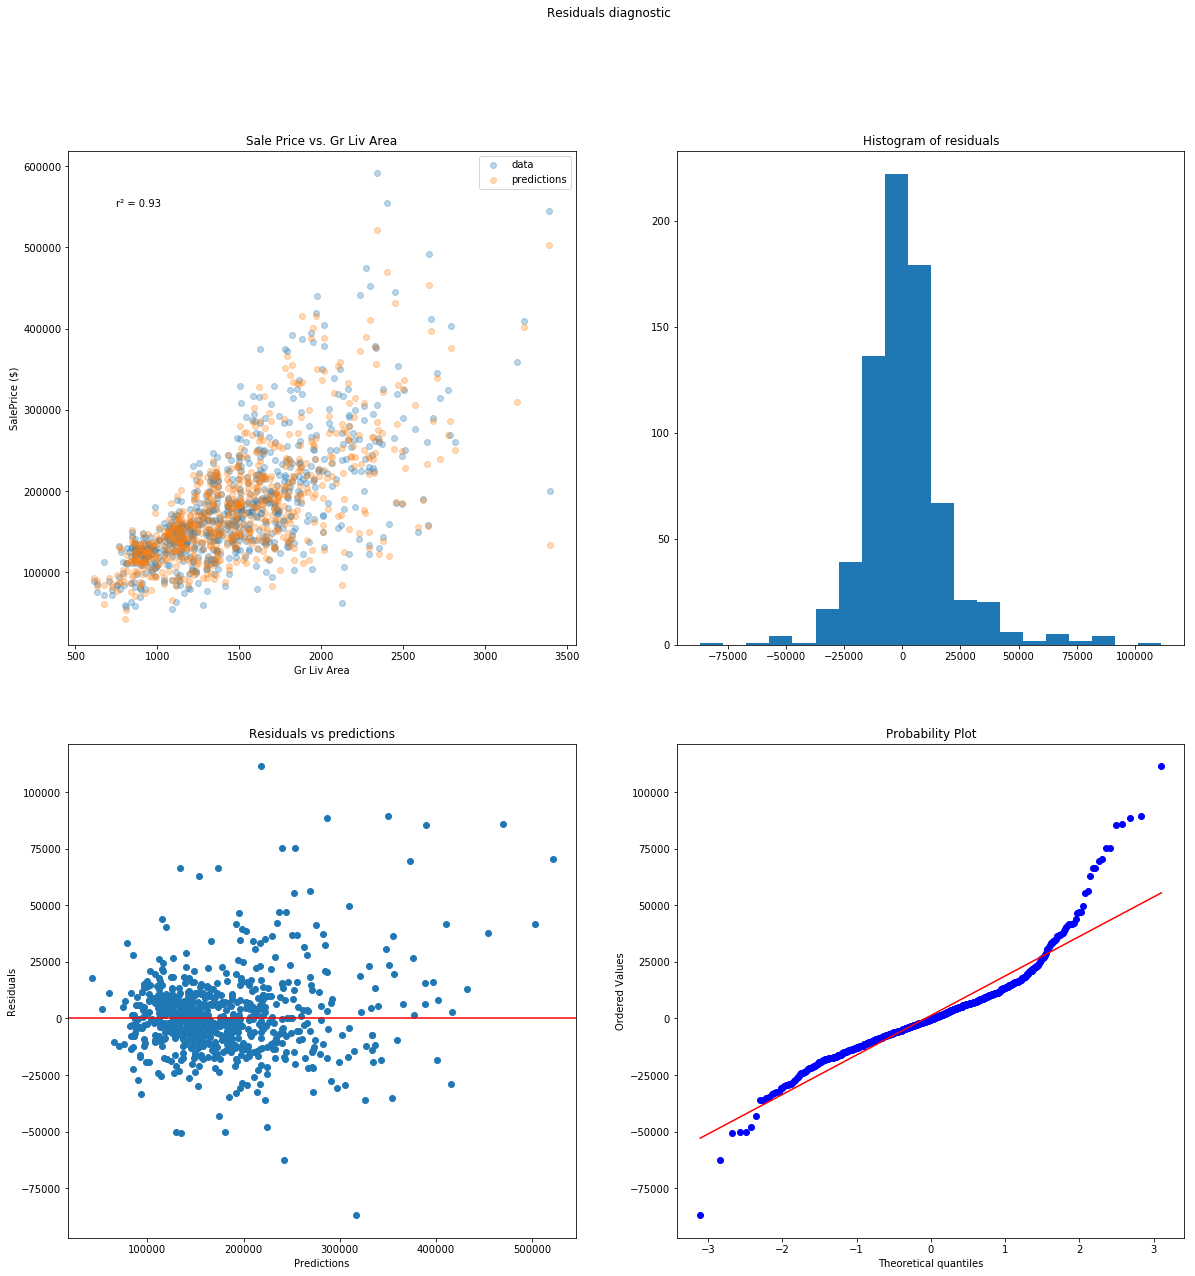

In [36]:
diagnose_plots(X_te['Gr Liv Area'], np.exp(y_te)-1, np.exp(regressor_complex_diag.predict(X_te))-1)

We can see that the distribution of the residuals is symetric. Their distributions tend to follow loosely a Normal distribution, the rigth tail being slightly more heavy. We can also see on the Rsiduals vs Predictions, that appart from predictions for houses with higher prices, the residuals tend to be homogeneously spread. 
This tells us that this model is a relatively good model, but caution should be advised on its accuracy when predicting high prices. 

Finally, the r² is 0.93, meaning that 93% of the variance can be explained by our model. While this is a good score, this is not much higher than the r² obtained with the intermediate model. 

## Performance comparison: 

Finally, we will compare the scores obtained by our 3 models with a base model, consisting in simply fitting the median of the Sale Prices.

In [37]:
# Compiling all scores on the held out data: 
all_MAE =pd.DataFrame({'Set': np.repeat(['Train', 'Test'], 4),
              'Model': ['Base (median)', 'Simple', 'Intermediate', 'Complex', 'Base (median)', 'Simple', 'Intermediate', 'Complex'], 
              'MAE ($)': [round(MAE(np.exp(y_val)-1, np.repeat(np.exp(y_val.median())-1, len(y_val)))),
                          round(MAE(np.exp(y_val)-1, np.exp(regressor_simple_diag.predict(X_val))-1)),
                          round(MAE(np.exp(y_val)-1, np.exp(regressor_inter_diag.predict(X_val))-1)),
                          round(MAE(np.exp(y_val)-1, np.exp(regressor_complex_diag.predict(X_val))-1)),
                          round(MAE(np.exp(y_te)-1, np.repeat(np.exp(y_val.median())-1, len(y_te)))),
                          round(MAE(np.exp(y_te)-1, np.exp(regressor_simple_diag.predict(X_te))-1)),
                          round(MAE(np.exp(y_te)-1, np.exp(regressor_inter_diag.predict(X_te))-1)),
                          round(MAE(np.exp(y_te)-1, np.exp(regressor_complex_diag.predict(X_te))-1))
                         ]
             })


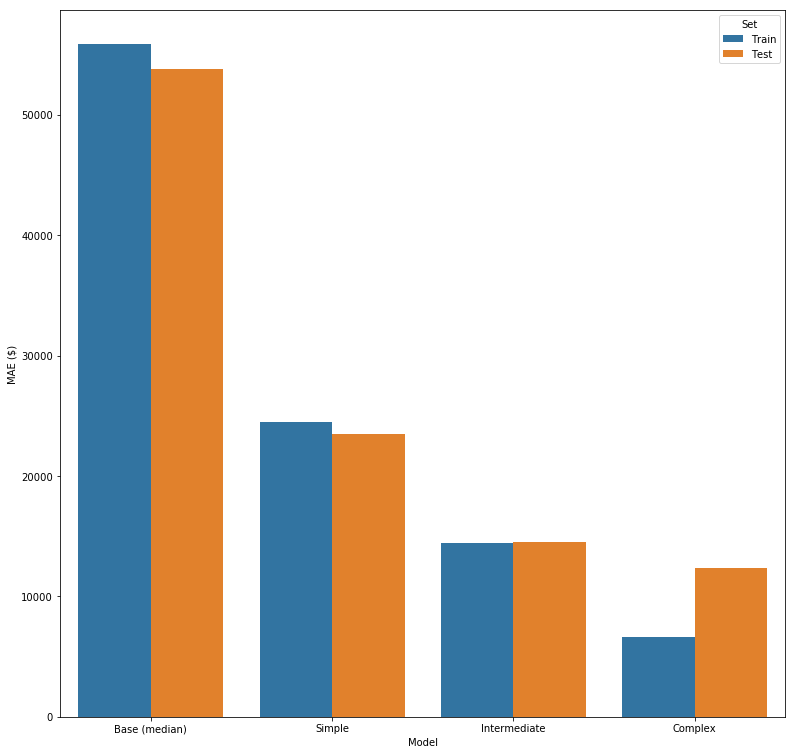

In [38]:
plt.figure(figsize = (13,13))
ax = sns.barplot(x="Model", y="MAE ($)", data=all_MAE, hue = 'Set')

plt.show()

We can see that all models, simple, intermediate and complex, perform better than the base model. In addition, the more complex the model, the better the performance, with the intermediate model being really close to the performance of the complex model. 

## 4. Predictions on the test set
Now that we have optimized our models, we will compute the predictions on the real test set

In [39]:
#Predictions on test set? 
#load test set
house_test = pd.read_csv("house-prices-test.csv", dtype = 'object')
conti_var.remove('SalePrice')
house_test[disc_var + conti_var] = house_test[disc_var+ conti_var].copy().astype(float)


In [40]:
#Simple model
#Final fit on the whole training set
onehot_columns = ['Overall Qual']
other_columns = [x  for y in  ['Gr Liv Area'] for x in all_additional_variables if y in x]

simple_categ_categories = np.array([np.sort(PandasPreprocessor().fit(house_raw).data_[x].unique()) for x in onehot_columns])


# One-hot encoding for non-numerical columns
onehot_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', categories = simple_categ_categories))
])

other_transformer = Pipeline([
    ('scaler', RobustScaler())
])

# Create preprocessor
preprocessor_model = ColumnTransformer([
    ('onehot', onehot_transformer, onehot_columns),
    ('other', other_transformer, other_columns)
])

regressor_simple=Pipeline([
    ('cleaning', PandasPreprocessor()),
    ('preprocessor', preprocessor_model),
    ('huber', HuberRegressor(max_iter = 1000000, alpha = best_params_simple['huber__alpha'], epsilon = best_params_simple['huber__epsilon']))
])

regressor_simple.fit(X, y)
y_pred_simple = pd.DataFrame({'PID': house_test['PID'], 
                              'SalePrice' : np.exp(regressor_simple.predict(house_test))-1})
y_pred_simple.describe()
y_pred_simple.to_csv('predictions-simple-model.csv', index=False)

In [41]:
#Inter model
#Final fit on the whole training set
inter_conti_var = ['Gr Liv Area', 'Year Built', 'Total Bsmt SF', 'Lot Area', 'Garage Area']
inter_categ_var = ['Overall Cond','Electrical', 'Central Air', 'Fireplace Qu',  'Sale Type', 'Sale Condition', 
                   'Overall Qual', 'MS Zoning', "MS SubClass", 'Neighborhood', 'Full Bath']
inter_categ_categories = np.array([np.sort(PandasPreprocessor().fit(house_raw).data_[x].unique()) for x in inter_categ_var])


# One-hot encoding for non-numerical columns
onehot_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', categories = inter_categ_categories))
])

other_transformer = Pipeline([
    ('scaler', RobustScaler())
])


onehot_columns = inter_categ_var
other_columns = [x  for y in inter_conti_var for x in all_additional_variables if y in x]
passthrough_columns = [id_var for id_var in other_columns if '_YN' in id_var]
other_columns = [id_var for id_var in other_columns if '_YN' not in id_var]


# Create preprocessor
preprocessor_model = ColumnTransformer([
    ('onehot', onehot_transformer, onehot_columns),
    ('other', other_transformer, other_columns),
    ('pass','passthrough', passthrough_columns)
])
regressor_inter=Pipeline([
    ('cleaning', PandasPreprocessor()),
    ('preprocessor', preprocessor_model),
    ('huber', HuberRegressor(max_iter = 1000000, alpha = best_params_inter['huber__alpha'], epsilon = best_params_inter['huber__epsilon']))
])

regressor_inter.fit(X, y)
y_pred_inter = pd.DataFrame({'PID': house_test['PID'], 
                              'SalePrice' : np.exp(regressor_inter.predict(house_test))-1})
y_pred_inter.describe()
y_pred_inter.to_csv('predictions-intermediate-model.csv', index=False)

In [42]:
#complex model
#Final fit on the whole training set

#Complex model: 

complex_conti_var = ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", 
                            "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", 
                            "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area", "Garage Area", 
                            "Wood Deck SF", "Open Porch SF", "Enclosed Porch", "3Ssn Porch",
                            "Screen Porch", "Pool Area", "Misc Val", "SalePrice", 
                            "Year Built", "Year Remod/Add", "Garage Yr Blt"
                           ]
complex_categ_var = [
                     "MS SubClass", "MS Zoning", "Street", "Alley",
                          "Land Contour", "Lot Config", "Neighborhood", "Condition 1", "Condition 2", 
                          "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                          "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", 
                          "Garage Type", "Misc Feature", "Sale Type", "Sale Condition", "Lot Shape", "Utilities", "Land Slope", "Overall Qual", 
                           "Overall Cond", "Exter Qual", "Exter Cond", "Bsmt Qual",
                           "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2",
                           "Heating QC", "Electrical", "Kitchen Qual", "Functional", 
                           "Fireplace Qu", "Garage Finish", "Garage Qual", "Garage Cond",
                           "Paved Drive", "Pool QC", "Fence", "Order",  
    "Bsmt Full Bath", "Bsmt Half Bath", 
                           "Full Bath", "Half Bath", "Bedroom AbvGr", "Kitchen AbvGr", "TotRms AbvGrd",
                           "Fireplaces",  "Garage Cars", "Mo Sold", "Yr Sold"
                          ]
complex_categ_categories = np.array([np.sort(PandasPreprocessor().fit(house_raw).data_[x].unique()) for x in complex_categ_var])


# One-hot encoding for non-numerical columns
onehot_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', categories = complex_categ_categories))
])

other_transformer = Pipeline([
    ('scaler', RobustScaler())
])


onehot_columns = complex_categ_var
other_columns = [x  for y in complex_conti_var for x in all_additional_variables if y in x]
passthrough_columns = [id_var for id_var in other_columns if '_YN' in id_var]
other_columns = [id_var for id_var in other_columns if '_YN' not in id_var]


# Create preprocessor
preprocessor_model = ColumnTransformer([
    ('onehot', onehot_transformer, onehot_columns),
    ('other', other_transformer, other_columns),
    ('pass','passthrough', passthrough_columns)
])
regressor_complex=Pipeline([
    ('cleaning', PandasPreprocessor()),
    ('preprocessor', preprocessor_model),
    ('huber', HuberRegressor(max_iter = 1000000, alpha = best_params_complex['huber__alpha'], epsilon = best_params_complex['huber__epsilon']))
])

regressor_complex.fit(X, y)
y_pred_complex = pd.DataFrame({'PID': house_test['PID'], 
                              'SalePrice' : np.exp(regressor_complex.predict(house_test))-1})
y_pred_complex.describe()
y_pred_complex.to_csv('predictions-complex-model.csv', index=False)

## Predictions scores on the Test Set
Our predictions were checked against the true values in the test set, using the self-checked tools. 
The resuls are displayes below: 


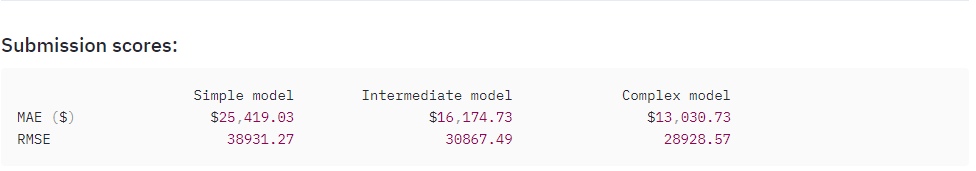

In [43]:
from IPython.display import Image
from IPython.core.display import HTML
from IPython.display import display
PATH = r"C:\Users\Valou\Documents\Machine Learning\Projects\house-prices\img"
Image(filename = PATH + "\Submission_scores.png", width=976, height=171)


These scores are slightly higher, but pretty similar to those obtained while training our models, meaning that we are not massively overfitting while training our models. 
In average, our predictions are 25,419 dollars away from the true prices with our simple model, 16,174 dollars away from the true prices with our intermediate model and 13,030 dollars away from the true prices with the complex model.

The distributions of the predicted prices are displayed below: 

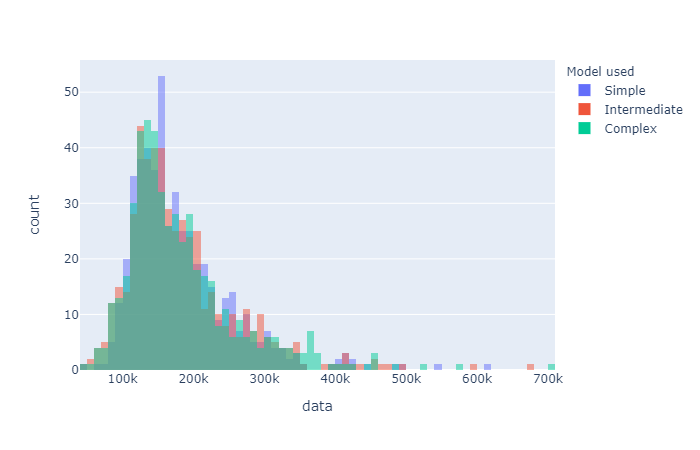

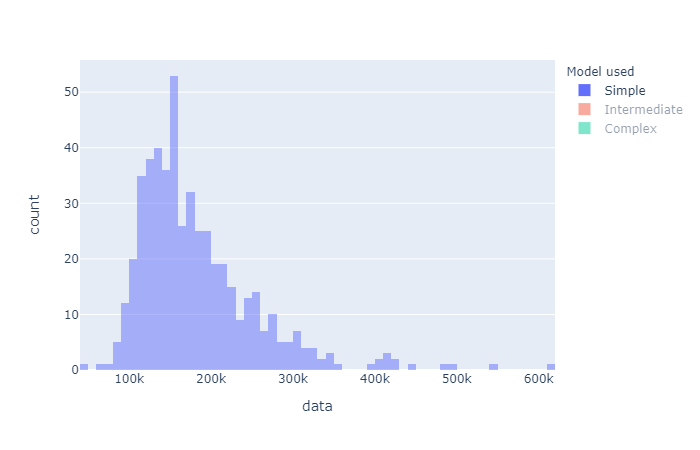

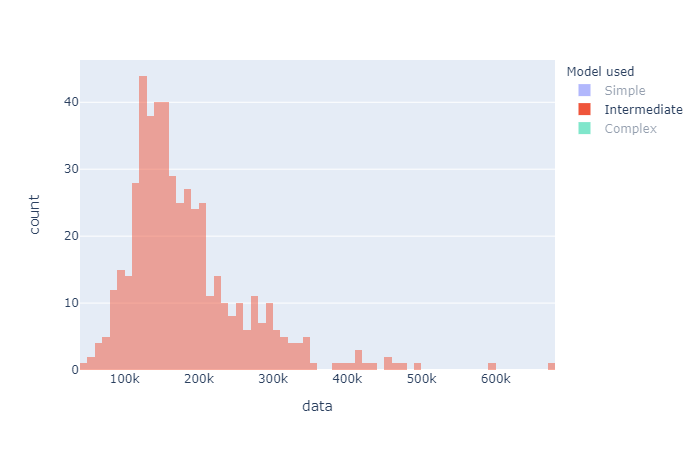

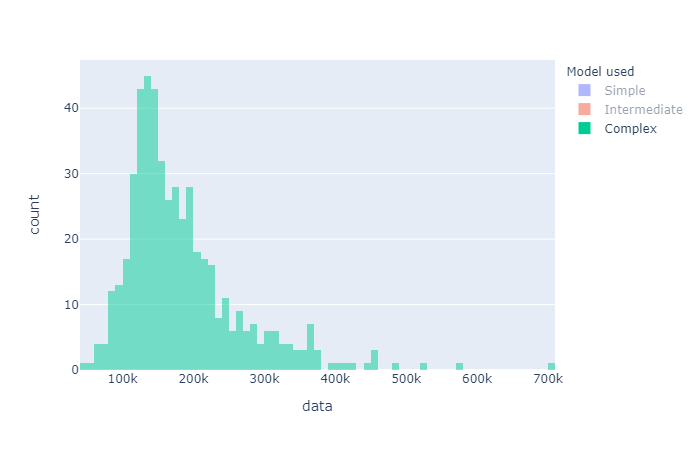

In [44]:
all_dist= Image(filename =PATH + "\prediction_distributions_all.png", width=700, height=450)
simp_dist= Image(filename =PATH + "\prediction_distributions_simple.png", width=700, height=450)
inter_dist= Image(filename =PATH + "\prediction_distributions_inter.png", width=700, height=450)
comp_dist= Image(filename =PATH + "\prediction_distributions_complex.png", width=700, height=450)
display(all_dist,simp_dist,inter_dist, comp_dist)


All the distributions are pretty similar in shape, with a peak around the 150K value. The Maximum prediction of the simple model was just avove 610K, while the intermediate and complex models have a maximum around the 700K mark. The ability to predict higher prices probably explain the better performances of the intermediate and complex models. 
Such results were as expected, as the the MAE was lower on the held out training data were higher for the intermediate and complex models compared to the simple model. 


## Discussion: 

### Results: 
The main goal of this project was to predict houses' sale prices. After an extensive Exploratory Data Analysis, we manage to highlights the most promising variables to this end and incorporate them in 3 linear models of increasing complexity. When fitting a base median the predicted prices were in average 56,000 dollars away from the true prices. Compared to this base model, all models performed better. Additionally, the performances of our models increased with the number of included variables. In average we were 25,419 dollars away from the true prices with our simple model, 16,174 dollars away from the true prices with our intermediate model and 13,030 dollars away from the true prices with the complex model. 

Setting up these models were the results of many choices that were motivated by the exploratory data analysis and could be discussed. 

### Outliers: 
One of the first choices we made after cleaning the data, was to include or remove outliers. Outliers in general hurt the predictive performance of a model, especially when they are extreme points with a lot of leverage (outliers on both extreme sides of the distributions). However, identifying true outliers is something that needs to be familiar of the studied data to be able to differentiate between a simply rare, but actual value and a true abnomaly that is not representative of the true distribution of the data. 
The documentation provided with the data, contains a note identifying observations that were true outliers. We followed the expert advice and removed these observations, but still experimented with a systematic detection of the outliers in the data, using the IQR method after transforming the predictors to have a symmetric distribution. However, after studying the impact of removing flagged outliers on the relationship with the Sale Price, we decided that the loss in information, was not worth it, as it would have systematically removed observations with high prices as well as houses with low prices characterized by the absence of a lot of features measured in the dateset (houses with no garage, no basement, etc.). This would have have introduced a bias that would have hurt our vapability to predict these types of houses. 
To compensate, we used the Huber regressor to fit our models, which is a regressor robust to outliers and adjust the weight given to extreme values. 

### Choice of predictors: 
Regarding the choice of the predictors to include in the models, all decisions were made by hand, after studying the bivariate distributions between Sale Price and all features. We based our decisions on figures, choosing the variables where a relationship appeared clearly (either with a scatterplot where a positive or negative slop was clearly apparent, or with categories with Price distributions minimally overlapping on violin plots for the categorical variables). We also used a spearman correlation matrix to filter out variables that were correlated with Sale Price and correlated between themselves, to limit ill-conditionning. 

More formal methods, such as the SelectKBest method, suggested by the team, could have been used. However, similarly as for dealing with outliers, we believe that knowledge of the data is something important when choosing features and we wanted to have contol on what was included in the model. As we saw as results of our predictions, the models we trained still obtained good results with our manual process. 
Point of ameliorations for this work would include: 
* trying out these automated methods to back up our choices with a more formal criteria for adding or not a variable, 
* investigating the inclusion of interaction term between features

### Feature engineering: 
Regarding feature engineering, we made the choice of decomposing some variables into 2 (or 3) variables, to  take into account the fact that some of the continuous variables were 0-inflated siince they didn't have a measure for some of these features (i.e.: 0 for garage area since the house had no garage). This helped us to not lose information contained in these variables, while still keeping their distribution. 
We also decided on the transformation of the continuous variables, based on scatter plots as well as on the residuals of a linear model between them and Sale Price to ensure that a linear relationshipexists between them. 
This approach presents some flows, as feature, might not be linearly related to the target variable on its own, but still be included in a multivariate model where the linearity, normality and homoscedasticity of the residuals is respected. However, this provided us with a good insight of the data. Moreover, the final model's residuals (at least for the intermediate and complex modles) were within reasonnable limits of the assumptions, giving us confidence in the accuracy of our predictions. 
Finally, it is interesting to note that the feature engineering performed was done with the main goal of having the best predictions, and not necessary the best interpretability. Indeed, we could question how to interpret the effect of the square of a year on the price. However, as the clear goal expressed for this project was the prediction of the SalePrice, we chose to include these feature with log/square-root transformation/polynomial terms, regardless of interpretability. 

### Closing thoughts:
Finally, we can note that performance in the complex model is only marginally better than in the intermediate model, despite adding a large number of variables. This shows that the variables that were chosen for the intermediate model already already managed to give a good desciption of the Sale Price. This was as expected, as the percentage of variance explained by our intermediate model on the held out training data was already 92%, while it only was 93% with the complex model. 
Even if the predictions were slightly better with the complex model, the computational cost was however way higher: 15 minutes for cross validation on the intermediate model vs 1 hour for the complex model. This means that, according to context (if the model needs to be run frequently for example), the intermediate model might still be the preferred one as the gain in precision would not be worth the loss in computational performance. 